In [2]:
import pandas as pd
import nltk, os, numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words=set(stopwords.words('english') + list(string.punctuation))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read and prepare data for further work

In [25]:
df = pd.read_csv('full_dataset_all_labels.csv')
#df = df.sample(10000)

In [4]:
def print_some_texts(columns, df):
    text_idxs = [47, 7240, 7241, 8013, 14500, 16500, 16304, 18300,  21750, 34036, 45159, 71920]
    for i in text_idxs:
        for column in columns:
            print(df[column].iloc[i])
#print_some_texts(['text'])

def tokenize(text):
    #print(text)
    text = preprocess_text(text)
    #print(text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation). (adapted from lab example)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in stop_words and len(token) > 2:
                filtered_tokens.append(token)
    return filtered_tokens
    

def preprocess_text(text):
    text = re.sub(r"http\S+", " ", text)            # remove urls
    text = re.sub("@[A-Za-z0-9]+","", text)         # remove twitter handle
    text = re.sub("&amp;","", text)                  # &amp; is a special character for ampersand
    text = re.sub('<USER>', '', text)               # remove '<USER>' as there are some such strings as user or url is masked with this string
    text = re.sub('<URL>', '', text)
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text)           # Remove punctuations
    text = text.lower()                             # Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text = re.sub("(\\d|\\W)+"," ",text)            # remove special characters and digits
    return text
    
    
def stemming(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [26]:
df['preprocessed_text']=df['text'].apply(preprocess_text)
df['tokenized_text']= df['preprocessed_text'].apply(tokenize) 
df['stems']= df['tokenized_text'].apply(stemming) 
df['lemmas']= df['tokenized_text'].apply(lemmatizing) 

In [27]:
labels = df['label'].unique()
#df.sample(5)

### CREATE UPSET PLOT

In [8]:
import upsetplot

Find top words for each category

In [9]:
k = 20
top_k_dict = {}
words_by_label_string = {}

for label in labels:
    tmp = df[df['label'] == label]['lemmas']
    tmp = tmp.apply(pd.Series).stack().reset_index(drop=True)
    words_by_label_string[label] = ' '.join(list(tmp.values))
    tmp = tmp.value_counts(normalize=True)[:k]
    top_k_dict[label] = tmp

Create list of all words that are in the top k words. 

In [10]:
all_top_words = []
for k,v in top_k_dict.items():
    all_top_words = [*all_top_words , *v.index]

all_top_words = list(set(all_top_words))

Create dataframe where each column is label and each row represents the word in top words, values are True/False, depends on if word is top in selected label.

In [11]:
upset_df = pd.DataFrame()
col_names = labels

for i, col in enumerate(labels):
    temp = []
    for w in all_top_words:
        if w in top_k_dict[col].index:
            temp.append(True)
        else:
            temp.append(False)
    upset_df[col] = temp
    
upset_df['c'] = 1
example = upset_df.groupby(labels.tolist()).count().sort_values('c')
example

c
abuse cyberbullying harassment hateful homophobic hostile identity_hate insult obscene offensive profane racist severe_toxic sexist slur  threat vulgar    
True  True          True       True    True       True    True          True   True    True      True    True   False        True   True  False  True     1
False False         False      False   False      True    False         False  False   True      False   False  False        False  False False  True     1
                                                                                                                             True   False False  False    1
                                       True       False   False         False  False   False     False   False  False        False  False False  False    1
True  True          True       True    True       True    False         True   True    True      True    False  False        True   True  False  True     1
...                                                                                                                                                      ..
False False         False      True    False      False   False         False  False   False     False   False  False        False  False False  False    7
                               False   False      False   False         False  False   False     True    False  False        False  False False  False    8
                                                                                                 False   False  False        True   False False  False    8
                                                                                                         True   False        False  False False  False   12
                                                                                                         False  False        False  False True   False   12

[64 rows x 1 columns]

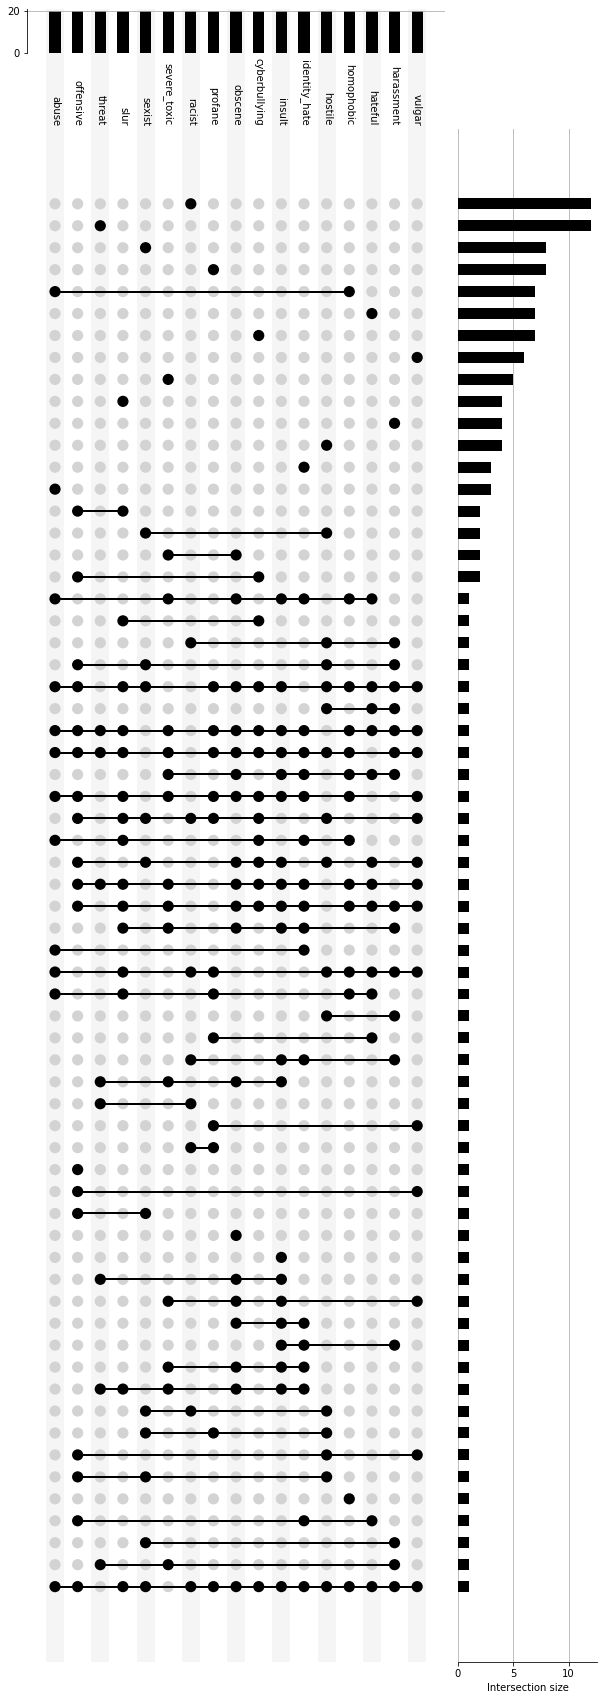

In [12]:
upsetplot.plot(example['c'], sort_by="cardinality",orientation='vertical')
plt.savefig("upsetplot", bbox_inches='tight', dpi=400)

## TFIDF TRY

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Create tfidf vectorizer and fit it on all data.

In [14]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(list(words_by_label_string.values()))
df_tfidf = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)

Array where each row represents one label and each column is certain word, (i,j) rating for j-th word in t-th document.

In [15]:
tfidf_array = tfIdf.toarray()

In [16]:
cosine_similarities = cosine_similarity(tfidf_array)
df_similar = pd.DataFrame(cosine_similarities, columns = labels, index = labels)

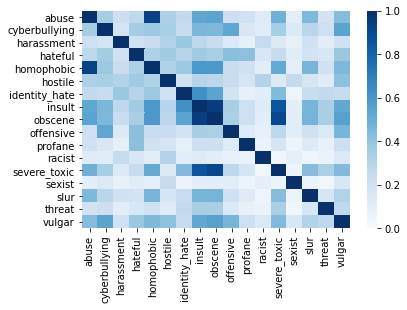

In [17]:
sns.heatmap(df_similar, vmin=0, vmax=1, cmap='Blues')
plt.savefig("heatmap", dpi=400, bbox_inches='tight')

## VIZUALIZATION OF FEW RANDOM DOCUMENTS

In [18]:
from yellowbrick.text import TSNEVisualizer,UMAPVisualizer

In [19]:
def visualize_tfidf_tsne(corpus_data,corpus_target,labels = True,alpha=0.9,metric=None):
    docs   = tfIdfVectorizer.transform(corpus_data)
    
    if labels is True:
        labels = corpus_target
    else:
        labels = None
    viz = TSNEVisualizer(alpha = alpha, colors = [plt.cm.gist_ncar(i) for i in np.linspace(0,0.9, len(set(labels)))])
    viz.fit(docs,labels)
    return viz.poof()

In [20]:
corpus = df[['label', 'lemmas']].sample(10000)
corpus['lemmas'] = corpus['lemmas'].apply(lambda x: ' '.join(x))
corpus_target = list(corpus['label'])
corpus_data = list(corpus['lemmas'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

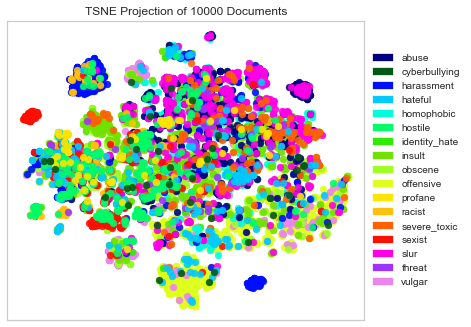

<AxesSubplot:title={'center':'TSNE Projection of 10000 Documents'}>

In [21]:
visualize_tfidf_tsne(corpus_data,corpus_target)

## TFIDF CLUSTERING

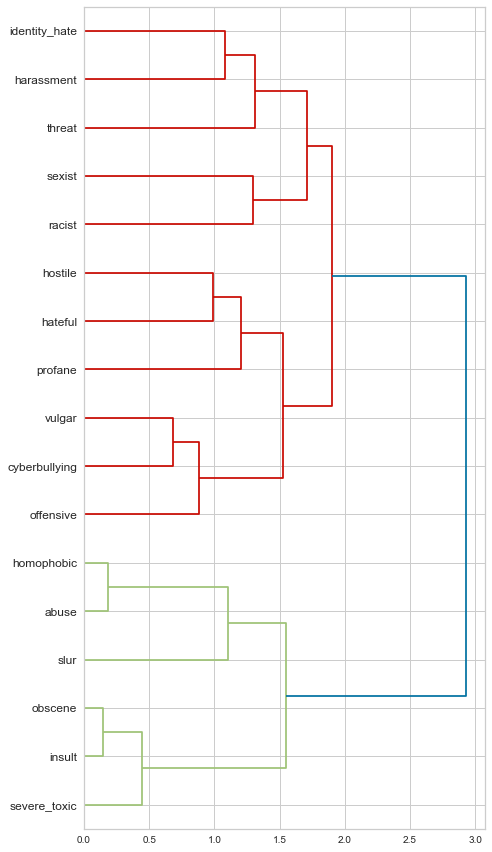

In [22]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(df_similar)

fig, ax = plt.subplots(figsize=(7, 12)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=labels);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('dendro.png', dpi=200, bbox_inches='tight')

## PLOT RANDOM VECTORS OF TWEETS AND THEN FURTHER WORK

In [7]:
import gensim
import gensim.downloader

In [8]:
model_gn_word2vec = gensim.downloader.load('word2vec-google-news-300')

In [88]:
sample = df[['label', 'lemmas']].sample(20000)
embeddings = []
# embeddings.append(model_gn[word]) 
# words.append(word)
j = 0
for i, row in sample.iterrows():
    embeddings.append([])
    #print(row['lemmas'])
    for w in row['lemmas']:
        try:
            embeddings[j].append(model_gn_word2vec[w])
        except KeyError:
            pass
    embeddings[j] = np.array(embeddings[j])
    embeddings[j] = np.mean(embeddings[j], axis=0)
    #print(embeddings[j])
    j+=1
sample['embedding'] = embeddings
average_sample = sample.groupby('label')['embedding'].apply(np.mean)

C:\ProgramData\Anaconda3\envs\ML_hw2\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\envs\ML_hw2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
from sklearn.decomposition import PCA
sm = np.matrix(average_sample.tolist())
pca = PCA(n_components=2)
fitted = pca.fit_transform(sm)
principalDf = pd.DataFrame(data = fitted, columns = ['pc1', 'pc2'], index = average_sample.index)
principalDf

,pc1,pc2
label,,
abuse,0.131370,0.072288
cyberbullying,0.096126,-0.154387
harassment,-0.172735,0.171187
hateful,-0.133311,-0.060574
homophobic,0.195774,0.066197
hostile,-0.391705,-0.116273
identity_hate,0.053979,0.114404
insult,0.061329,-0.013773
obscene,0.101924,-0.014565


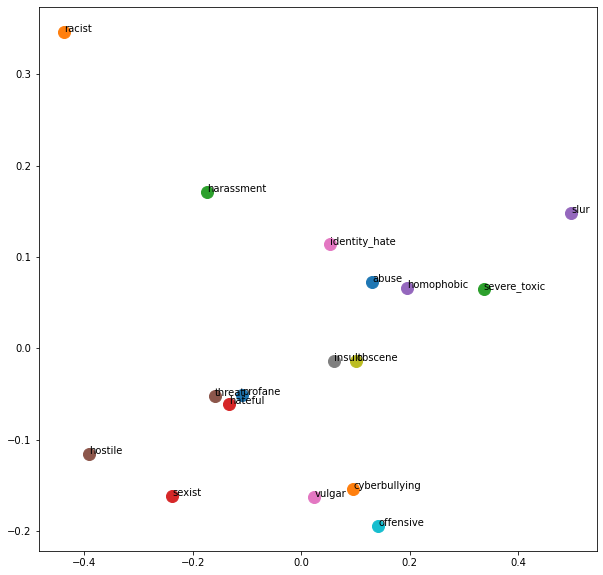

In [90]:

# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i,group in principalDf.iterrows():
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=12, label=i)
    ax.annotate(i, (group[0], group[1]))
plt.show()